Import the needed packages and ml modules 

In [1]:
import numpy as np
import pandas as pd

import xarray as xr
import os
import sys

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchsummary import summary
from sklearn.model_selection import KFold
import torch.nn.functional as F
from sklearn.metrics import r2_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import folium
import folium.plugins
import pandas as pd
import xarray as xr
import branca
import branca.colormap as cm

Read events and filter amd split them into 65:35

In [2]:
#Read event list from file
event_list = np.loadtxt('../data/events/sample_events1212.txt', dtype='str')

#filter events with lower than threshold of 0.1 at atleast one station
offshore_threshold = 0.1
onshore_threshold = 0.25

allpts_max = np.loadtxt('../data/info/grid0_allpts87_alleve1212.offshore.txt', dtype='str',skiprows=1)
regions = ['CT','SR']

GaugeNo_CT = list(range(35,44)) #for Catania
GaugeNo_SR = list(range(53,58)) #for Siracusa
All_Gauges = GaugeNo_SR #+ GaugeNo_CT 

inun_info = np.loadtxt('../data/info/C_SR_alleve1212.onshore.txt', dtype='str',skiprows=1)
Inun_Max = inun_info[:,2]

Gauge_Max = allpts_max[:,All_Gauges]
maxPerEve = Gauge_Max.astype(float).max(axis=1)

#filter events greater than thresholds for gauge and min inundation depth
offshore_check = maxPerEve>offshore_threshold
onshore_check = Inun_Max.astype(float)>onshore_threshold
overall_check = offshore_check & onshore_check
event_list = event_list[overall_check]

#set seed
np.random.seed(123)

#shuffle events
np.random.shuffle(event_list)

#split events in train and test and validation as 60:20:20
train_events = event_list[:int(len(event_list)*0.65)] 
test_events = event_list[int(len(event_list)*0.65):]

print(len(train_events), len(test_events))

#save events in file
np.savetxt('../data/events/shuffled_events_SR.txt', event_list, fmt='%s')
np.savetxt('../data/events/train_events_SR.txt', train_events, fmt='%s')
np.savetxt('../data/events/test_events_SR.txt', test_events, fmt='%s')


767 413


Read the netcdf files for offshore and onshore data and prepare training, validation and test batch

In [11]:
#files
sim_dir = '../data/simu/PS_manning003/'
Hpath_format = sim_dir + '/{:s}/C_{:s}.nc'
Zpath_format = sim_dir + '/{:s}/{:s}_defbathy.nc'
TSpath_format = sim_dir + '/{:s}/grid0_ts.nc'

reg = regions[1]
eve = event_list[1]
print(reg, eve)

H_grids = xr.open_dataset(Hpath_format.format(eve,reg)) #grid file of depth
Z_grids = xr.open_dataset(Zpath_format.format(eve,reg)) #grid file of bathymetry
TS_pts = xr.open_dataset(TSpath_format.format(eve)) #pts file of time series

# # #TODO: should you remove the deformation from both inundation height and offshore time series eta when starting to use events nearshore and causing bigger deformation?

# # # t=TS_pts.eta
# # # t_SR = t[:,GaugeNo_SR] #5 (pts) x 481 (ts) x no of events 

# # # z = Z_grids.z #land mask

# # # h = H_grids.max_height
# # # h_SR = h.where(z.values > 0) # 948(y) x 1300(x) x no of events

# # # sys.getsizeof(t_SR)


SR E02020N3739E02658N3366-PS-Mur_PYes_Var-M888_E02434N3452_S004


In [12]:
h_array = np.zeros((len(event_list), 948, 1300))  # 948(y) x 1300(x) x no of events
t_array = np.zeros((len(event_list), 480, 5))  # 480(ts) x 5(pts) x no of events

for i,eve in enumerate(event_list):
    print('processing',i,'of',len(event_list),eve,end='\r')
    H_grids = xr.open_dataset(Hpath_format.format(eve,reg)) #grid file of depth
    Z_grids = xr.open_dataset(Zpath_format.format(eve,reg)) #grid file of bathymetry
    TS_pts = xr.open_dataset(TSpath_format.format(eve)) #pts file of time series
    t=TS_pts.eta
    t_SR = t[1:,GaugeNo_SR] #5 channels of 480 timesetps x no of events 
    z = Z_grids.z #land mask
    h = H_grids.max_height
    h_SR = h.where(z.values > 0) # 948(y) x 1300(x) x no of events
    
    h_SR = h_SR.values
    t_SR = t_SR.values

    h_SR[np.isnan(h_SR)] = 0
    t_SR[np.isnan(t_SR)] = 0

    #update to the empty array
    h_array[i,:,:] = h_SR
    t_array[i,:,:] = t_SR

#arrange dimensions to be (no of events, 5 channels, 480 time steps)
t_array = np.transpose(t_array, (0,2,1))



try normalisation and std of data, not sure how it impacts the extrapolation ability of model

In [ ]:
# # #normalize the data to 0-1 for h
# # np.savetxt('../data/processed/h_SR_normpara.txt',
# #            np.hstack((h_array.min(),h_array.max()))) 
# # h_array = (h_array - h_array.min())/(h_array.max() - h_array.min())    

# # #standardize t
# # np.savetxt('../data/processed/t_SR_stdpara.txt',
# #            np.hstack((t_array.mean(),t_array.std())))
# # t_array = (t_array - t_array.mean())/t_array.std()

# #save the data
# np.save('../data/processed/h_SR.npy', h_array)
# np.save('../data/processed/t_SR.npy', t_array)

In [13]:
#save an numpy binary
onshore_map = np.memmap('../data/processed/h_SR.dat',
                         mode='w+',
                         dtype=float,
                         shape=(h_array.shape[0], h_array.shape[1], h_array.shape[2]))
onshore_map[:] = h_array[:]

offshore_map = np.memmap('../data/processed/t_SR.dat',
                         mode='w+',
                         dtype=float,
                         shape=(t_array.shape[0], t_array.shape[1], t_array.shape[2]))
offshore_map[:] = t_array[:]


Quick check of a data sample

In [ ]:
# # h_array  = np.load('../data/processed/h_SR.npy')
# # t_array  = np.load('../data/processed/t_SR.npy')


# data = h_array[492,:,:]
# data = np.ma.masked_where(data == 0, data)
# print(data.max())
# plt.imshow(data, cmap='jet',interpolation='none')
# plt.colorbar()
# plt.show()

# data_t = t_array[492,0,:]
# plt.plot(data_t)
# plt.show()


size of overall dataset

In [ ]:
# #size of files
# print('size of h_SR.npy:',os.path.getsize('../data/processed/h_SR.npy')/1e6,'MB')
# print('size of t_SR.npy:',os.path.getsize('../data/processed/t_SR.npy')/1e6,'MB')
# # sys.getsizeof(t_array)/1e6
# # sys.getsizeof(h_array)/1e6

Read input

In [18]:
# input data
# t_array = np.load('../data/processed/t_SR.npy')
# t_array = np.transpose(t_array, (0,2,1))
# t_array = t_array[:,2,:].reshape(-1,1,480)
# d_array = np.memmap('../data/processed/d_SR.dat',
#                 mode='r+',
#                 dtype=float,
#                 shape=(1180, 948, 1300))

t_array = np.memmap('../data/processed/t_SR.dat',
                mode='r+',
                dtype=float,
                shape=(1180, 5, 480))

print('all:',t_array.shape)
data = t_array[:int(len(t_array)*0.65)]
test_data = t_array[int(len(t_array)*0.65):]
print('train:',data.shape)
print('test:',test_data.shape)

all: (1180, 5, 480)
train: (767, 5, 480)
test: (413, 5, 480)


In [14]:
# #check if the data is correct ttarray[0,0,0] == t_array[0,0,0]
# print(tt_array[0,0,0] == t_array[0,0,0])


True


Autoencoder model for offshore time series

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, ninputs=5,t_len = 480, ch_list = [32,64,96], zdim = 50 ):
        super(Autoencoder, self).__init__()
        # more channels mean more fine details, more resolution 
        # less channel and layers less likely to overfit so better maximas and minimas
        # more accuracy but slower and more memory and data needed to train
        self.ch_list = ch_list

        # define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv1d(ninputs, ch_list[0], kernel_size=3, padding=1),   
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,nn.AvgPool1d(kernel_size=2, stride=2),         
            nn.Conv1d(ch_list[0], ch_list[1], kernel_size=3, padding=1),   
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,nn.AvgPool1d(kernel_size=2, stride=2),         
            nn.Conv1d(ch_list[1], ch_list[2], kernel_size=3, padding=1), 
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.1),nn.Flatten(),
            nn.Linear(int(t_len*self.ch_list[-1]/(2**len(ch_list))), zdim),          

        )
        # define decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(zdim,int(t_len*self.ch_list[-1]/(2**len(ch_list)))),
            nn.Unflatten(1, (ch_list[-1], int(t_len/(2**len(ch_list))))) ,
            nn.ConvTranspose1d(ch_list[2], ch_list[1], kernel_size=4, padding=1, stride= 2),  
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,
            nn.ConvTranspose1d(ch_list[1], ch_list[0], kernel_size=4, padding=1, stride= 2), 
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,
            nn.ConvTranspose1d(ch_list[0], ninputs, kernel_size=4, padding=1, stride= 2), 
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,
        )

        # self.latenspace =nn.Sequential(
        #     nn.Linear(int(t_len*self.ch_list[-1]/(2**len(ch_list))), zdim), # 96 x 60 ---> 50 Latent variables #divide by 4 for 2 layers and 8 for three layers
        #     nn.Linear(zdim,int(t_len*self.ch_list[-1]/(2**len(ch_list)))) # 10 Latent variables ---> 96 x 60 )
        # )
    def encode(self, x):
        x = self.encoder(x)
        # x = x.view(x.size(0), -1) # flatten the output
        # print(x.shape)
        return x
    
    def decode(self, x):
        # x = x.view(x.size(0), self.ch_list[-1], -1) # unflatten the output
        x = self.decoder(x)
        # print(x.shape)
        return x
    
    def forward(self, x):
        x = self.encode(x)  
        # x = self.latenspace(x)
        x = self.decode(x)
        return x

def trainAE(num_folds,batch_size,nepochs,lr,n,t,z,channels):
    print('Training Autoencoder:',channels)
    
    if num_folds >1:
        print('Using K-fold Cross Validation')

        # Define k-fold indices
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        splits = kf.split(data)

        # Loop over folds
        fold_losses = [] 
        for idx, (train_idx, val_idx) in enumerate(splits):
            t_epoch_losses = []
            es_epoch_losses = []
            # Split data into train and validation sets
            x_train, x_val = data[train_idx], data[val_idx]

            # Create PyTorch DataLoader objects
            train_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_train))
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            val_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_val))
            val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            # Initialize model, optimizer, and loss function
            model = Autoencoder(ninputs = n ,t_len = t,
                                ch_list = channels, zdim = z)
            model.to('cuda')
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            criterion = nn.MSELoss()

            # Train model
            for epoch in range(nepochs):
                train_loss = 0
                es_losses = 0
                for batch_idx, (batch_data,) in enumerate(train_loader):
                    optimizer.zero_grad()
                    batch_data = batch_data.to('cuda')
                    recon_data = model(batch_data)
                    loss = criterion(recon_data, batch_data)
                    train_loss += loss.item()
                    loss.backward()
                    optimizer.step()
                
                for batch_idx, (batch_data,) in enumerate(val_loader):
                    batch_data = batch_data.to('cuda')
                    recon_data = model(batch_data)
                    loss = criterion(recon_data, batch_data)
                    es_losses += loss.item()

                print(f"Fold {idx + 1},epoch:{epoch},training loss: {train_loss / len(train_loader):.5f},val loss: {es_losses / len(val_loader):.5f}", end="\r")
                
                t_epoch_losses.append(train_loss / len(train_loader))
                es_epoch_losses.append(es_losses / len(val_loader))
            
            #plot training/val loss
            plt.plot(t_epoch_losses, color='blue')
            plt.plot(es_epoch_losses, color='red')
            plt.title(f"Training loss for fold {idx + 1}")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.yscale('log')
            plt.savefig(f"./../model/plot/fold{idx + 1}_training_loss.png")   
            plt.clf()

            print(f"Fold {idx + 1},epoch:{epoch},training loss: {train_loss / len(train_loader):.5f}")    
            
            # Validation model
            model.eval()
            with torch.no_grad():
                val_loss = 0
                for batch_idx, (batch_data,) in enumerate(val_loader):
                    batch_data = batch_data.to('cuda')
                    recon_data = model(batch_data)
                    loss = criterion(recon_data, batch_data)
                    val_loss += loss.item()
            print(f"Fold {idx + 1}, validation loss: {val_loss / len(val_loader):.5f}")
            #save fold loss
            fold_losses.append(val_loss / len(val_loader))
            
        #average validation loss accross folds
        print(f"Average validation loss: {np.mean(fold_losses):.5f} for zdim = {z}")
        #save model
        torch.save(model, f"./../model/out/model_offshore_zdim_{z}")

    elif num_folds == 0:
  
        # Create PyTorch DataLoader objects
        train_dataset = torch.utils.data.TensorDataset(torch.Tensor(data[0:int(len(data)*0.99)]))   
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_dataset = torch.utils.data.TensorDataset(torch.Tensor(data[int(len(data)*0.99):]))
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_dataset = torch.utils.data.TensorDataset(torch.Tensor(test_data))
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model, optimizer, and loss function
        model = Autoencoder(ninputs = n ,t_len = t,
                                ch_list = channels, zdim = z)
        model.to('cuda')
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        t_epoch_losses = []
        es_epoch_losses = []
        test_epoch_losses = []

        # Train model
        for epoch in range(nepochs):
            train_loss = 0
            es_losses = 0
            test_loss = 0
            for batch_idx, (batch_data,) in enumerate(train_loader):
                optimizer.zero_grad()
                batch_data = batch_data.to('cuda')
                recon_data = model(batch_data)
                loss = criterion(recon_data, batch_data)
                train_loss += loss.item()
                loss.backward()
                optimizer.step()
                    
            for batch_idx, (batch_data,) in enumerate(val_loader):
                batch_data = batch_data.to('cuda')
                recon_data = model(batch_data)
                vloss = criterion(recon_data, batch_data)
                es_losses += vloss.item()
            
            for batch_idx, (batch_data,) in enumerate(test_loader):
                batch_data = batch_data.to('cuda')
                recon_data = model(batch_data)
                tloss = criterion(recon_data, batch_data)
                test_loss += tloss.item()

            print(f"NoFold,epoch:{epoch},training loss: {train_loss / len(train_loader):.5f},val loss: {es_losses / len(val_loader):.5f},test loss:{test_loss / len(test_loader):.5f}", end="\r")
            
            t_epoch_losses.append(train_loss / len(train_loader))
            es_epoch_losses.append(es_losses / len(val_loader))
            test_epoch_losses.append(test_loss / len(test_loader))
            
            #plot training/val loss
            plt.plot(t_epoch_losses, color='blue')
            plt.plot(es_epoch_losses, color='red')
            plt.plot(test_epoch_losses, color='green')
            plt.title(f"Training loss for Nofold")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.yscale('log')
            plt.savefig(f"./../model/plot/offshoreshore_Nofold_loss_ch_{channels}.png")   
            plt.clf()

            if epoch % 100 == 0:
                #save model
                torch.save(model, f"./../model/out/model_offshoreshore_ch_{channels}_epoch_{epoch}")
    
    with open(f"./../model/out/model_offshore_ch_loss.txt", "a") as text_file:
        text_file.write(f"ch: {channels}, train loss: {t_epoch_losses[-1]}, val loss: {es_epoch_losses[-1]}, test loss: {test_loss / len(test_loader):.5f}\n")
    text_file.close()   


In [19]:
reg = 'SR'

#create regional folders
if not os.path.exists(f"./../model/{reg}/out/"):
    os.makedirs(f"./../model/{reg}/out/")
if not os.path.exists(f"./../model/{reg}/plot/"):
    os.makedirs(f"./../model/{reg}/plot/")

n = data.shape[1]
t = data.shape[2]
batch_size = 50
num_epochs = 1001
learning_rate = 0.0001
num_folds = 0
z = 64
channels = [64,128,256]

# trainAE(num_folds,batch_size,num_epochs,learning_rate,n,t,z,channels)

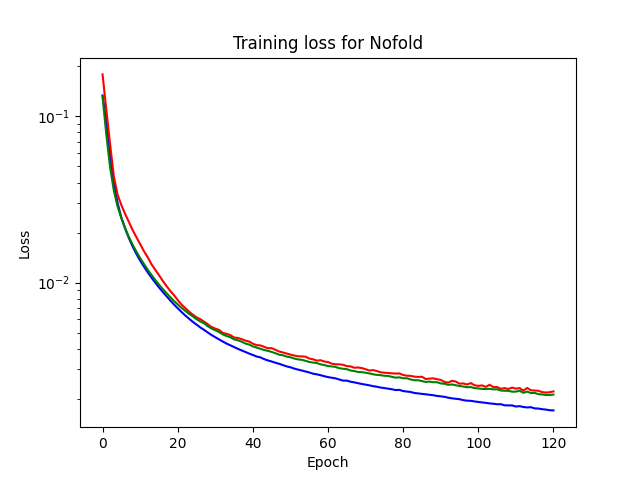

In [20]:
#open image file
from PIL import Image
img = Image.open(f'./../model/{reg}/plot/offshoreshore_Nofold_loss_ch_{channels}.png')
img

In [21]:
#read model from file
model = torch.load(f"./../model/{reg}/out/model_offshoreshore_ch_{channels}_epoch_1000")
summary(model,(n,t))
model.eval()
# Test model for final evaluation
criterion = nn.MSELoss()
print(test_data.shape)
test_dataset = torch.tensor(test_data, dtype=torch.float32).to('cuda')
print(test_dataset.shape)
recon_data = model(test_dataset)
tloss = criterion(recon_data, test_dataset)
print(f"Test loss: {tloss :.5f}", end="\r")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 480]           1,024
         LeakyReLU-2              [-1, 64, 480]               0
         AvgPool1d-3              [-1, 64, 240]               0
            Conv1d-4             [-1, 128, 240]          24,704
         LeakyReLU-5             [-1, 128, 240]               0
         AvgPool1d-6             [-1, 128, 120]               0
            Conv1d-7             [-1, 256, 120]          98,560
         LeakyReLU-8             [-1, 256, 120]               0
         AvgPool1d-9              [-1, 256, 60]               0
          Dropout-10              [-1, 256, 60]               0
          Flatten-11                [-1, 15360]               0
           Linear-12                   [-1, 64]         983,104
           Linear-13                [-1, 15360]         998,400
        Unflatten-14              [-1, 

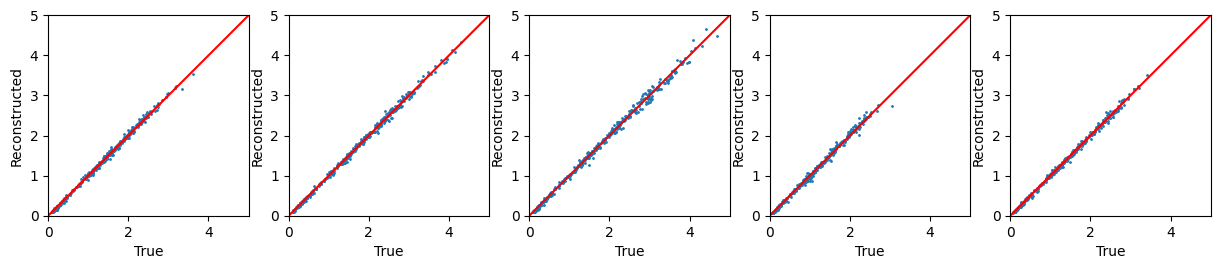

In [22]:
# Plot results all gauge max for all events

plt.figure(figsize=(15, 3))
for g in range(5):
    plt.subplot(1, 5, g+1)
    plt.scatter(test_data[:, g, :].max(axis=1), recon_data[:, g, :].cpu().detach().numpy().max(axis=1), s=1)
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    plt.xlabel('True')
    plt.ylabel('Reconstructed')
plt.show()

recon_data = recon_data[:, :, :].cpu().detach().numpy()

In [25]:
all_ids = np.loadtxt('../data/events/shuffled_events.txt', dtype='str',skiprows=0)
test_ids = all_ids[int(len(all_ids)*0.65):]
eve_info = pd.read_csv('../data/info/about_alleve1212_PS.txt', sep='\t')

#check performance per event
eve_perf = []
for eve_no,eve in enumerate(test_ids):
    eve_perf.append([eve_no,r2_score(test_data[eve_no, 0, :], recon_data[eve_no, 0, :]),
                                r2_score(test_data[eve_no, 1, :], recon_data[eve_no, 1, :]),
                                r2_score(test_data[eve_no, 2, :], recon_data[eve_no, 2, :]),
                                r2_score(test_data[eve_no, 3, :], recon_data[eve_no, 3, :]),
                                r2_score(test_data[eve_no, 4, :], recon_data[eve_no, 4, :])])

#count of events less than 
eve_perf = np.array(eve_perf)

#add column with average r2 score
eve_perf = np.append(eve_perf, np.mean(eve_perf[:,1:], axis=1).reshape(-1,1), axis=1)

print(eve_perf[eve_perf[:,6]<0.9].shape[0])

29


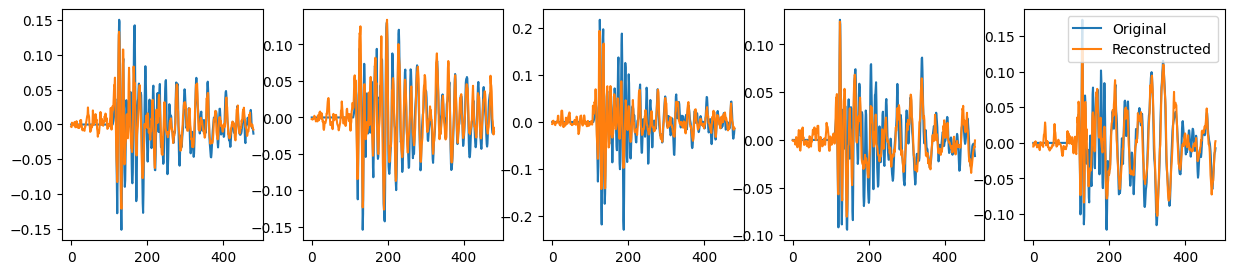

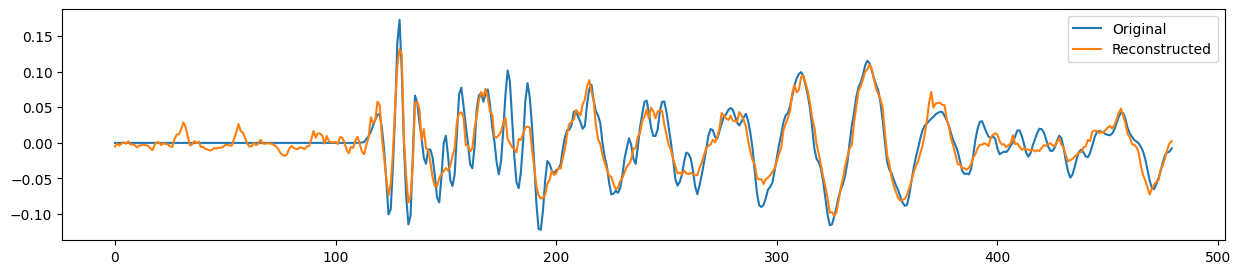

In [27]:
# Plot results all gauge
eve_no = 155
plt.figure(figsize=(15, 3))
for g in range(5):
    plt.subplot(1, 5, g+1)
    plt.plot(test_data[eve_no, g, :], label="Original")
    plt.plot(recon_data[eve_no, g, :], label="Reconstructed")
plt.legend()
plt.show()
# Plot results for one gauge
plt.figure(figsize=(15, 3))
plt.plot(test_data[eve_no, 4, :], label="Original")
plt.plot(recon_data[eve_no, 4, :], label="Reconstructed")
plt.legend()
plt.show()